 data set link: https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

In [46]:
#basic imports 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix

In [15]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
df = pd.read_csv("../IMDB Dataset.csv")

In [3]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [5]:
df['len'] = df['review'].apply(len)

In [6]:
df.head()

,review,sentiment,len
0,One of the other reviewers has mentioned that ...,positive,1761
1,A wonderful little production. <br /><br />The...,positive,998
2,I thought this was a wonderful way to spend ti...,positive,926
3,Basically there's a family where a little boy ...,negative,748
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1317


In [7]:
df.dropna(inplace=True)

/Users/aadityajoshi/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


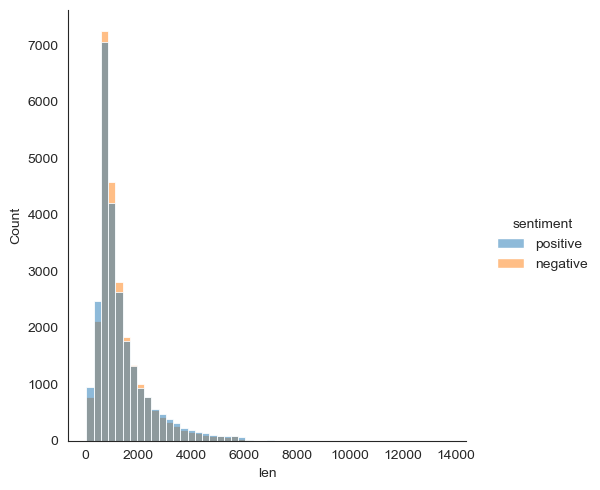

In [19]:
sns.displot(x='len',data = df,bins=50,hue='sentiment')
#positive and negative reviews have the same average length

In [13]:
df['len'].sort_values(ascending=False)[:10]
#no outliers

31481    13704
40521    12988
31240    12930
31436    12129
5708     10363
12647    10321
3024      9951
42946     9420
3654      9345
43821     8969
Name: len, dtype: int64

<Axes: xlabel='sentiment', ylabel='count'>

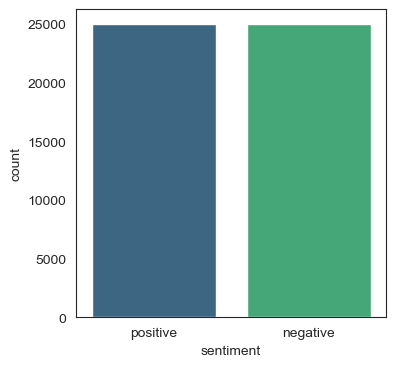

In [20]:
plt.figure(figsize=(4,4))
sns.set_style('white')
sns.countplot(x='sentiment',data=df,palette='viridis')

   ## check for blanks

In [21]:
blanks = []
for i,rv,lb,le in df.itertuples():
    if type(rv) == str:
        if rv.isspace():
            blanks.append(i)
blanks
#no missing values

[]

### remove punct,stopwords, lemmatize/stemming,

In [27]:
import spacy 
nlp = spacy.load('en_core_web_lg')

In [23]:
def clean(text):
    doc = nlp(text.lower())
    text = ' '.join([token.text for token in doc if not token.is_stop and not token.is_punct])
    return text
    

In [25]:
#example review
df['review'][1]

'A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only "has got all the polari" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams\' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master\'s of comedy and his life. <br /><br />The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional \'dream\' techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwell\'s murals decorating every surface) are terribly well d

In [30]:
#applying clean text function to review
df['review'] = df['review'].apply(clean)

In [31]:
df['review'][1]

'wonderful little production < br /><br />the filming technique unassuming- old time bbc fashion gives comforting discomforting sense realism entire piece < br /><br />the actors extremely chosen- michael sheen got polari voices pat truly seamless editing guided references williams diary entries worth watching terrificly written performed piece masterful production great master comedy life < br /><br />the realism comes home little things fantasy guard use traditional dream techniques remains solid disappears plays knowledge senses particularly scenes concerning orton halliwell sets particularly flat halliwell murals decorating surface terribly'

## create two columns of review one where stemming is used and one where lemmatization is used

In [35]:
#stemming
import nltk
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()
df['stem_review'] = df['review'].apply(lambda rev : stemmer.stem(rev))

In [36]:
df['stem_review'].head()

0    reviewers mentioned watching 1 oz episode hook...
1    wonderful little production < br /><br />the f...
2    thought wonderful way spend time hot summer we...
3    basically family little boy jake thinks zombie...
4    petter mattei love time money visually stunnin...
Name: stem_review, dtype: object

In [39]:
#lemmatization
def lemmatize_text(text):
    #pass text as a doc object
    doc = nlp(text.lower())
    #lemmatize it 
    lemma = ' '.join([token.lemma_ for token in doc])
    return lemma
    

In [40]:
#testing the fucntion
lemmatize_text('hello how are you')

'hello how be you'

In [41]:
df['lemma_review'] = df['review'].apply(lemmatize_text)

In [61]:
df.head()

,review,sentiment,len,stem_review,lemma_review
0,reviewers mentioned watching 1 oz episode hook...,1,1761,reviewers mentioned watching 1 oz episode hook...,reviewer mention watch 1 oz episode hook right...
1,wonderful little production < br /><br />the f...,1,998,wonderful little production < br /><br />the f...,wonderful little production < br /><br />the f...
2,thought wonderful way spend time hot summer we...,1,926,thought wonderful way spend time hot summer we...,think wonderful way spend time hot summer week...
3,basically family little boy jake thinks zombie...,0,748,basically family little boy jake thinks zombie...,basically family little boy jake think zombie ...
4,petter mattei love time money visually stunnin...,1,1317,petter mattei love time money visually stunnin...,petter mattei love time money visually stunnin...


In [60]:
#encoding label
sent_map = {'positive':1,'negative':0}
df['sentiment'] = df['sentiment'].replace(sent_map)

### comparing raw text vs stemmed text vs lemmatized text 

### using only the Bag of words(Bow) model

In [43]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer

### models - RFC , Decision Tree and Naive Bayes

In [62]:
#data split
text_raw = df['review']
text_stem = df['stem_review']
text_lemm = df['lemma_review']
label = df['sentiment']

### splitting for all three texts

In [63]:
text_raw_train,text_raw_test,label_train,label_test = train_test_split(text_raw,label,test_size=0.3,random_state=42)

In [64]:
text_stem_train,text_stem_test,label_train,label_test = train_test_split(text_stem,label,test_size=0.3,random_state=42)

In [65]:
text_lemm_train,text_lemm_test,label_train,label_test = train_test_split(text_lemm,label,test_size=0.3,random_state=42)

## creating pipelines

In [89]:
from sklearn.tree import DecisionTreeClassifier
bow_dtree_raw = Pipeline([('bow',CountVectorizer()),
                     ('dtree',DecisionTreeClassifier())])
bow_dtree_stem = Pipeline([('bow',CountVectorizer()),
                     ('dtree',DecisionTreeClassifier())])
bow_dtree_lemm = Pipeline([('bow',CountVectorizer()),
                     ('dtree',DecisionTreeClassifier())])

##### dtree with raw text 
##### roc_auc = 0.73 , accuracy =0.73

In [91]:
bow_dtree_raw.fit(text_raw_train,label_train)
pred_bow_dtree_raw = bow_dtree_raw.predict(text_raw_test)
print(classification_report(label_test,pred_bow_dtree_raw))

              precision    recall  f1-score   support

           0       0.72      0.73      0.73      7411
           1       0.74      0.73      0.73      7589

    accuracy                           0.73     15000
   macro avg       0.73      0.73      0.73     15000
weighted avg       0.73      0.73      0.73     15000



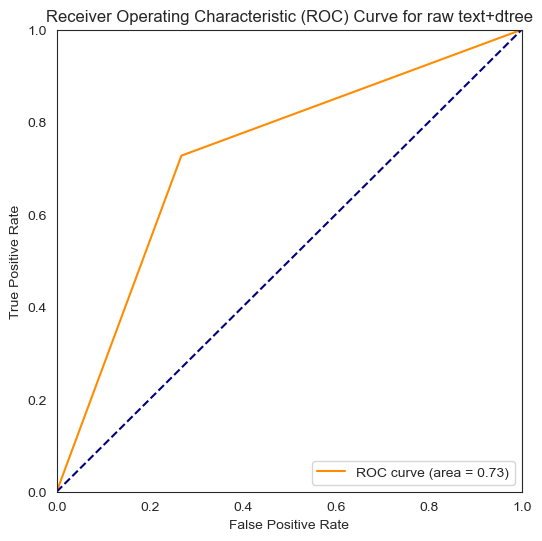

In [112]:
from sklearn.metrics import auc,roc_curve
#roc curve for dtree + raw text
#calculate fpr,tpr
prob_pred = bow_dtree_raw.predict_proba(text_raw_test)
preds = prob_pred[:,1]
fpr, tpr, threshold = roc_curve(label_test,preds)
roc_auc_dtree_raw = auc(fpr,tpr)
#plotting
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='darkorange', lw=1.5, label='ROC curve (area = %0.2f)' % roc_auc_dtree_raw )
plt.plot([0,1],[0,1],lw=1.5,linestyle='--',color='navy')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for raw text+dtree')
plt.legend(loc='lower right')
plt.show()


#### Dtree with stemmed text
##### roc_auc = 0.73 , accuracy =0.73

In [94]:
bow_dtree_stem.fit(text_stem_train,label_train)
pred_bow_dtree_stem = bow_dtree_stem.predict(text_stem_test)
print(classification_report(label_test,pred_bow_dtree_stem))

              precision    recall  f1-score   support

           0       0.73      0.73      0.73      7411
           1       0.74      0.73      0.73      7589

    accuracy                           0.73     15000
   macro avg       0.73      0.73      0.73     15000
weighted avg       0.73      0.73      0.73     15000



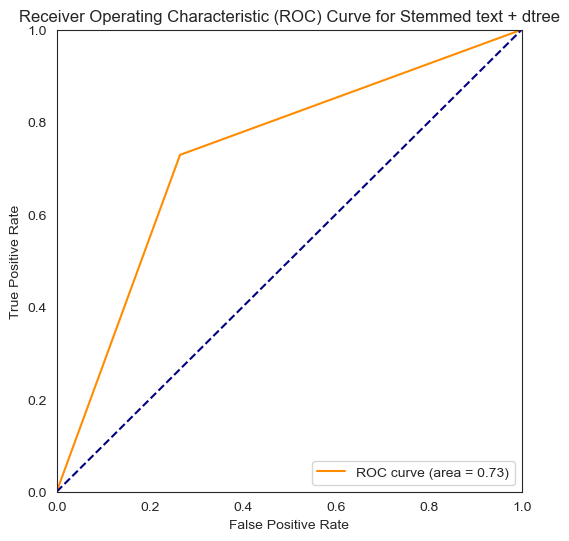

In [113]:
prob_pred = bow_dtree_stem.predict_proba(text_stem_test)
preds = prob_pred[:,1]
fpr, tpr, threshold = roc_curve(label_test,preds)
roc_auc_dtree_stem = auc(fpr,tpr)
#plotting
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='darkorange', lw=1.5, label='ROC curve (area = %0.2f)' % roc_auc_dtree_stem)
plt.plot([0,1],[0,1],lw=1.5,linestyle='--',color='navy')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Stemmed text + dtree')
plt.legend(loc='lower right')
plt.show()

#### dtree with lemmatized text
##### roc_auc = 0.73 , accuracy =0.73

In [96]:
bow_dtree_lemm.fit(text_lemm_train,label_train)
pred_bow_dtree_lemm = bow_dtree_lemm.predict(text_lemm_test)
print(classification_report(label_test,pred_bow_dtree_lemm))

              precision    recall  f1-score   support

           0       0.72      0.73      0.73      7411
           1       0.73      0.73      0.73      7589

    accuracy                           0.73     15000
   macro avg       0.73      0.73      0.73     15000
weighted avg       0.73      0.73      0.73     15000



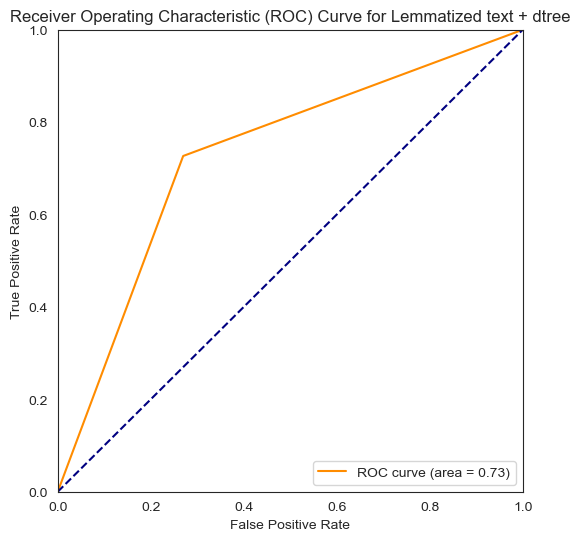

In [114]:
prob_pred = bow_dtree_lemm.predict_proba(text_lemm_test)
preds = prob_pred[:,1]
fpr, tpr, threshold = roc_curve(label_test,preds)
roc_auc_dtree_lemm = auc(fpr,tpr)
#plotting
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='darkorange', lw=1.5, label='ROC curve (area = %0.2f)' % roc_auc_dtree_lemm)
plt.plot([0,1],[0,1],lw=1.5,linestyle='--',color='navy')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Lemmatized text + dtree')
plt.legend(loc='lower right')
plt.show()

## RFC pipelines

In [98]:
from sklearn.ensemble import RandomForestClassifier
bow_rfc_raw = Pipeline([('bow',CountVectorizer()),
                     ('rfc',RandomForestClassifier())])
bow_rfc_stem = Pipeline([('bow',CountVectorizer()),
                     ('rfc',RandomForestClassifier())])
bow_rfc_lemm = Pipeline([('bow',CountVectorizer()),
                     ('rfc',RandomForestClassifier())])

#### RFC with raw text
##### roc_auc = 0.93 , accuracy =0.86

In [99]:
bow_rfc_raw.fit(text_raw_train,label_train)
pred_bow_rfc_raw = bow_rfc_raw.predict(text_raw_test)
print(classification_report(label_test,pred_bow_rfc_raw))

              precision    recall  f1-score   support

           0       0.86      0.86      0.86      7411
           1       0.86      0.86      0.86      7589

    accuracy                           0.86     15000
   macro avg       0.86      0.86      0.86     15000
weighted avg       0.86      0.86      0.86     15000



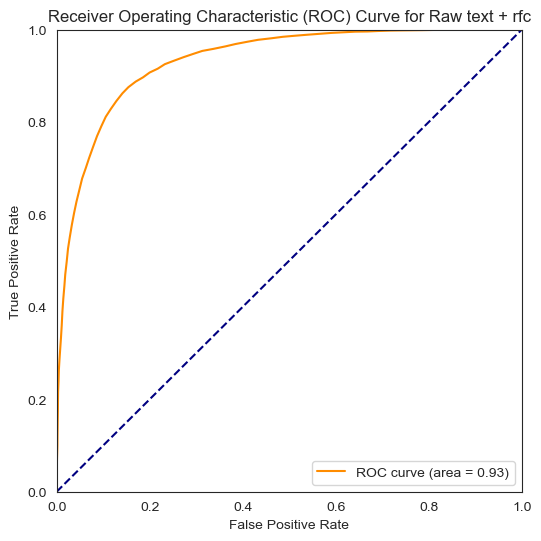

In [115]:
prob_pred = bow_rfc_raw.predict_proba(text_raw_test)
preds = prob_pred[:,1]
fpr, tpr, threshold = roc_curve(label_test,preds)
roc_auc_rfc_raw = auc(fpr,tpr)
#plotting
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='darkorange', lw=1.5, label='ROC curve (area = %0.2f)' % roc_auc_rfc_raw)
plt.plot([0,1],[0,1],lw=1.5,linestyle='--',color='navy')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Raw text + rfc')
plt.legend(loc='lower right')
plt.show()

### RFC with stemmed text
##### roc_auc = 0.93 , accuracy =0.86

In [101]:
bow_rfc_stem.fit(text_stem_train,label_train)
pred_bow_rfc_stem = bow_rfc_stem.predict(text_stem_test)
print(classification_report(label_test,pred_bow_rfc_stem))

              precision    recall  f1-score   support

           0       0.85      0.86      0.86      7411
           1       0.86      0.85      0.86      7589

    accuracy                           0.86     15000
   macro avg       0.86      0.86      0.86     15000
weighted avg       0.86      0.86      0.86     15000



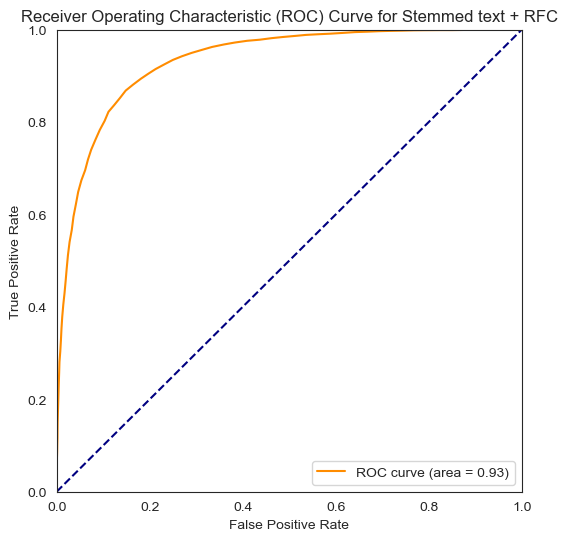

In [116]:
prob_pred = bow_rfc_stem.predict_proba(text_stem_test)
preds = prob_pred[:,1]
fpr, tpr, threshold = roc_curve(label_test,preds)
roc_auc_rfc_stem = auc(fpr,tpr)
#plotting
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='darkorange', lw=1.5, label='ROC curve (area = %0.2f)' % roc_auc_rfc_stem )
plt.plot([0,1],[0,1],lw=1.5,linestyle='--',color='navy')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Stemmed text + RFC')
plt.legend(loc='lower right')
plt.show()

#### RFC with Lemmtized
##### roc_auc = 0.93 , accuracy =0.86

In [103]:
bow_rfc_lemm.fit(text_lemm_train,label_train)
pred_bow_rfc_lemm = bow_rfc_lemm.predict(text_lemm_test)
print(classification_report(label_test,pred_bow_rfc_lemm))

              precision    recall  f1-score   support

           0       0.84      0.85      0.85      7411
           1       0.86      0.85      0.85      7589

    accuracy                           0.85     15000
   macro avg       0.85      0.85      0.85     15000
weighted avg       0.85      0.85      0.85     15000



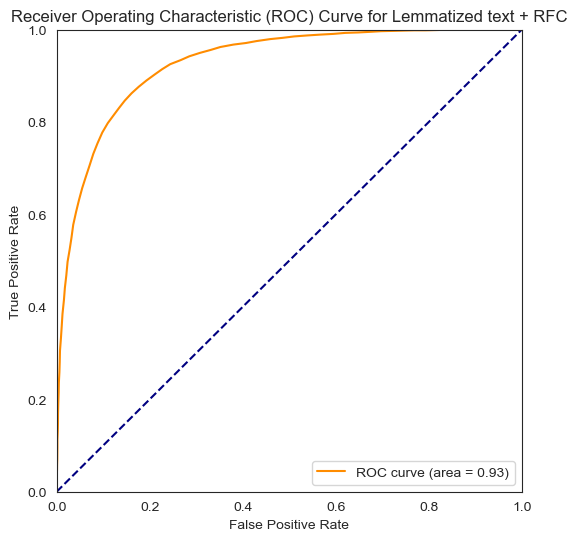

In [117]:
prob_pred = bow_rfc_lemm.predict_proba(text_lemm_test)
preds = prob_pred[:,1]
fpr, tpr, threshold = roc_curve(label_test,preds)
roc_auc_rfc_lemm = auc(fpr,tpr)
#plotting
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='darkorange', lw=1.5, label='ROC curve (area = %0.2f)' % roc_auc_rfc_lemm)
plt.plot([0,1],[0,1],lw=1.5,linestyle='--',color='navy')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Lemmatized text + RFC')
plt.legend(loc='lower right')
plt.show()

## Naive Bayes pipelline

In [105]:
from sklearn.naive_bayes import MultinomialNB
bow_nb_raw = Pipeline([('bow',CountVectorizer()),
                     ('naive bayes',MultinomialNB())])
bow_nb_stem = Pipeline([('bow',CountVectorizer()),
                     ('naive bayes',MultinomialNB())])
bow_nb_lemm = Pipeline([('bow',CountVectorizer()),
                     ('naive bayes',MultinomialNB())])

### Naive Bayes with Raw text
##### roc_auc = 0.92 , accuracy =0.86

In [106]:
bow_nb_raw.fit(text_raw_train,label_train)
pred_bow_nb_raw = bow_nb_raw.predict(text_raw_test)
print(classification_report(label_test,pred_bow_nb_raw))

              precision    recall  f1-score   support

           0       0.84      0.88      0.86      7411
           1       0.87      0.84      0.86      7589

    accuracy                           0.86     15000
   macro avg       0.86      0.86      0.86     15000
weighted avg       0.86      0.86      0.86     15000



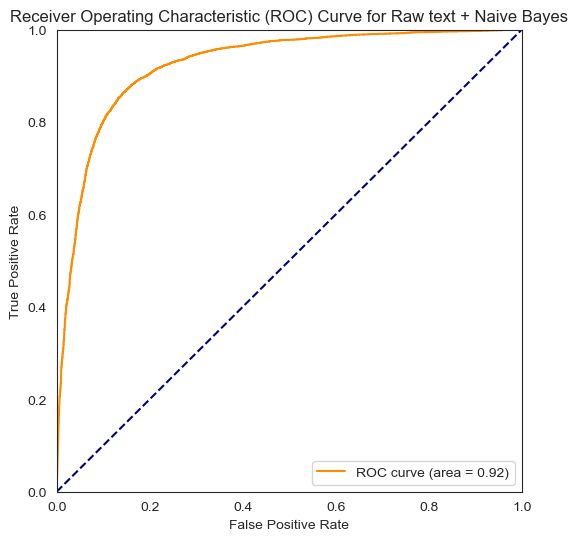

In [119]:
prob_pred = bow_nb_raw.predict_proba(text_raw_test)
preds = prob_pred[:,1]
fpr, tpr, threshold = roc_curve(label_test,preds)
roc_auc_nb_raw = auc(fpr,tpr)
#plotting
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='darkorange', lw=1.5, label='ROC curve (area = %0.2f)' % roc_auc_nb_raw)
plt.plot([0,1],[0,1],lw=1.5,linestyle='--',color='navy')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Raw text + Naive Bayes')
plt.legend(loc='lower right')
plt.show()

### Naive Bayes with Stemmed text
##### roc_auc = 0.92 , accuracy =0.86

In [108]:
bow_nb_stem.fit(text_stem_train,label_train)
pred_bow_nb_stem = bow_rfc_stem.predict(text_stem_test)
print(classification_report(label_test,pred_bow_nb_stem))

              precision    recall  f1-score   support

           0       0.85      0.86      0.86      7411
           1       0.86      0.85      0.86      7589

    accuracy                           0.86     15000
   macro avg       0.86      0.86      0.86     15000
weighted avg       0.86      0.86      0.86     15000



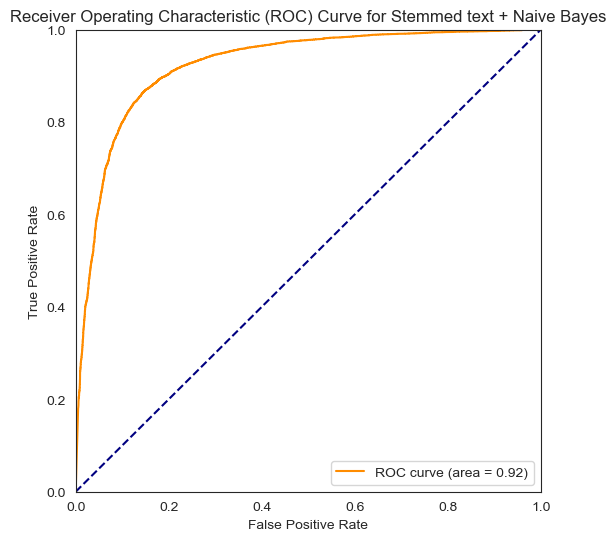

In [120]:
prob_pred = bow_nb_stem.predict_proba(text_stem_test)
preds = prob_pred[:,1]
fpr, tpr, threshold = roc_curve(label_test,preds)
roc_auc_nb_stem = auc(fpr,tpr)
#plotting
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='darkorange', lw=1.5, label='ROC curve (area = %0.2f)' % roc_auc_nb_stem)
plt.plot([0,1],[0,1],lw=1.5,linestyle='--',color='navy')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Stemmed text + Naive Bayes')
plt.legend(loc='lower right')
plt.show()

### Naive Bayes with Lemmatized text
##### roc_auc = 0.92 , accuracy =0.85

In [110]:
bow_nb_lemm.fit(text_lemm_train,label_train)
pred_bow_nb_lemm = bow_nb_lemm.predict(text_lemm_test)
print(classification_report(label_test,pred_bow_nb_lemm))

              precision    recall  f1-score   support

           0       0.84      0.87      0.85      7411
           1       0.87      0.83      0.85      7589

    accuracy                           0.85     15000
   macro avg       0.85      0.85      0.85     15000
weighted avg       0.85      0.85      0.85     15000



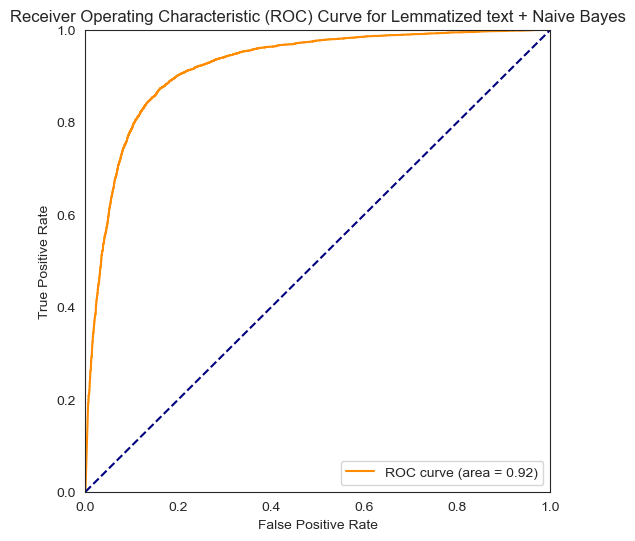

In [121]:
prob_pred = bow_nb_lemm.predict_proba(text_lemm_test)
preds = prob_pred[:,1]
fpr, tpr, threshold = roc_curve(label_test,preds)
roc_auc_nb_lemm = auc(fpr,tpr)
#plotting
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='darkorange', lw=1.5, label='ROC curve (area = %0.2f)' % roc_auc_nb_lemm )
plt.plot([0,1],[0,1],lw=1.5,linestyle='--',color='navy')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Lemmatized text + Naive Bayes')
plt.legend(loc='lower right')
plt.show()

## Final Scores

In [146]:
roc_scores = pd.DataFrame([roc_auc_dtree_raw,roc_auc_dtree_stem,roc_auc_dtree_lemm,roc_auc_rfc_raw,roc_auc_rfc_stem,roc_auc_rfc_lemm,roc_auc_nb_raw,roc_auc_nb_stem,roc_auc_nb_lemm],['dtree_raw','dtree_stem','dtree_lemm','rfc_raw','rfc_stem','rfc_lemm','nb_raw','nb_stem','nb_lemm'],columns=['ROC_scores'])

In [147]:
roc_scores

,ROC_scores
dtree_raw,0.729559
dtree_stem,0.731900
dtree_lemm,0.728488
rfc_raw,0.932908
rfc_stem,0.932868
rfc_lemm,0.927989
nb_raw,0.924655
nb_stem,0.924190
nb_lemm,0.920998


<Axes: >

<Figure size 800x800 with 0 Axes>

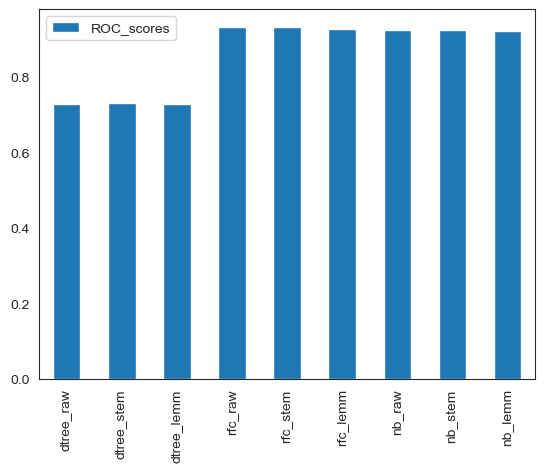

In [150]:
plt.figure(figsize=(8,8))
roc_scores.plot(kind='bar')

In [151]:
roc_scores['ROC_scores'].max()

0.9329080544835477

### RFC with raw text produced the best ROC_AUC Score